|<div style="width:300px"><img src="https://www.ufz.de/static/custom/weblayout/DefaultInternetLayout/img/logos/ufz_transparent_de_blue.png" width="300"/></div>|<div style="width:300px"><img src="https://discourse.opengeosys.org/uploads/default/original/1X/a288c27cc8f73e6830ad98b8729637a260ce3490.png" width="300"/></div>|<div style="width:330px"><img src="https://github.com/nagelt/Teaching_Scripts/raw/9d9e29ecca4b04eaf7397938eacbf116d37ddc93/Images/TUBAF_Logo_blau.png" width="300"/></div>|
|---|---|--:|

In <cite>Bourgeat et al. (2013)</cite> a numerical experiment is presented which investigates the transport behaviour of hydrogen in clay rock. This test example was investigated by several institutions using different simulation tools and the results were then compared in detail.

To verify the phase transition, the diffusive mass transport and the two-phase behaviour, this numerical experiment was recalculated with the TH2M process class. The material parameters and boundary conditions used essentially correspond to those of the experiment and are summarised as follows:


| Parameter                      | Symbol | Value | Unit |
|--------------------------------|:------:|------|---------|
| binary diffusion coefficient | $D$              | 3.0e-9   | Pa  |
| viscosity liquid            | $\mu_\text{LR}$  | 1.0e-3   | Pa s  |
| viscosity gas               | $\mu_\text{GR}$  | 9.0e-6   | Pa s  |
| Henry-coefficient            | $H$              | 7.65e-6  | mol Pa$^{-1}$m$^{-3}$  |
| molar mass hydrogen          | $M_\mathrm{H_2}$ | 2.0e-3   | kg mol$^{-1}$  |
| molar mass water             | $M_\mathrm{H_2O}$| 1.0e-2   | kg mol$^{-1}$  |
| density liquid               | $\rho_\text{LR}$ | eq. (1)  | kg m$^{-3}$  |
| intrinsic permeability       | $\mathbf{k}$     | 5.0e-20  | m$^2$  |
| porosity                     | $\phi$           | 0.15     | 1  |

The van Genuchten model was used as the saturation relation with $m=$0.329 and $p_b$=2.0e6 Pa, $s_\mathrm{L}^\mathrm{res}=$0.4 and $s_\mathrm{G}^\mathrm{res}=$0.0. The relative permeabilities $k^\mathrm{rel}_\mathrm{L}$ and $k^\mathrm{rel}_\mathrm{G}$ were determined using the van Genuchten and van Genuchten-Mualem models, respectively.

Unlike in the cited article, the density of the liquid phase was not considered constant, but was represented by a linear equation of state of the form

$$
\rho_\text{LR}=\rho^\text{ref}_\text{LR}\left(1+\chi_{c,\text{L}}c^\text{C}_\text{L}\right) \;\;\;(1)
$$

Here, $\rho^\text{ref}_\text{LR}$=1000 kg$^{-3}$ is a reference density and $\chi_{c,\text{L}}=M_{H_2}{\rho^\text{ref}_\text{LR}}^{-1}$=2.0e-6 m$^{3}$mol$^{-1}$ is the slope of the function with respect to the hydrogen concentration.

This deviation from the specifications in <cite>Bourgeat et al. (2013)</cite> is necessary because the phase transition model in TH2M evaluates the ratio of the densities of solvent and solution to calculate the dissolved gas fraction.
Therefore, the equation of state must take into account the concentration of dissolved gases, even if the actual influence on the density seems negligible.

![](figures/Bourgeat_concept.png#one-half)

The experiment considers a 200 m long, porous quasi-1D region, at the left edge of which a hydrogen mass flow is injected. This injection is kept constant for 500,000 years and then stopped.
The chosen mass flow is low enough that all the injected hydrogen is initially dissolved in the liquid phase and is transported there primarily by diffusion.

The validity of the test is carried out by comparing the variables gas saturation, gas pressure and water pressure with the results of various codes from <cite>Bourgeat et al. (2013)</cite>.

---

Bourgeat, A. P., Granet, S., & Smaï, F. (2013). Compositional two-phase flow in saturated–unsaturated porous media: benchmarks for phase appearance/disappearance. Simulation of Flow in Porous Media, 1–29. https://doi.org/10.1515/9783110282245.81

In [1]:
import os
from pathlib import Path

out_dir = Path(os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out"))
if not out_dir.exists():
    out_dir.mkdir(parents=True)

In [2]:
import numpy as np
import ogstools as ogs

model = ogs.Project(input_file="bourgeat.prj", output_file=f"{out_dir}/modified.prj")
# This Jupyter notebook version of this test runs not as far as its cTest-counterpart,
# it'll stop after approx. 800 ka
model.replace_text(2.5e13, xpath="./time_loop/processes/process/time_stepping/t_end")


# The cTest version shows only a few output-timesteps while this version is supposed to
# output much higher resolution time steps to be able to compare the results. Thus, every
# timestep will be written and the maximum timestep-size of the adaptive time stepping
# method will be reduced drastically
time_end = 1e11
model.replace_text(
    time_end, xpath="./time_loop/processes/process/time_stepping/maximum_dt"
)

# The following for loop generates a text with output times,which is then replaced by
# the project file API (ogstools.Project) in the project file.
new_line = "\u000A"
timesteps = str(0.4 * 1e6 * 86400 * 365.25) + new_line
for t in np.arange(0.6, 1.1, 0.1):
    timesteps += str(t * 1e6 * 86400 * 365.25) + new_line

model.replace_text(1, xpath="./time_loop/output/timesteps/pair/each_steps")
model.replace_text(timesteps, xpath="./time_loop/output/fixed_output_times")
model.write_input()

# Run OGS
model.run_model(logfile=f"{out_dir}/out.txt", args=f"-o {out_dir} -m .")

OGS finished with project file modified.prj.
Execution took 37.83957624435425 s


In [3]:
# Colors
cls = ["#e6191d", "#337fb8", "#4eae4c", "#984ea3", "#984ea3", "#feff32"]

In [4]:
import vtuIO

# Read PVD-output
pvdfile = vtuIO.PVDIO(f"{out_dir}/result_bourgeat.pvd", dim=2)
point = {"A": (0.0, 0.0, 0.0)}
time = pvdfile.timesteps

saturation = pvdfile.read_time_series("saturation", point)
gas_pressure = pvdfile.read_time_series("gas_pressure", point)
liquid_pressure = pvdfile.read_time_series("liquid_pressure_interpolated", point)

num_results = [1.0 - saturation["A"], gas_pressure["A"], liquid_pressure["A"]]

time_years = time / 365.2425 / 86400

In [5]:
import pandas as pd

# Read the reference data from CSV files
refs = [
    pd.read_csv("references/bourgeat_sG.csv"),
    pd.read_csv("references/bourgeat_pGR.csv"),
    pd.read_csv("references/bourgeat_pLR.csv"),
]

header = list(refs[0].keys())

In [6]:
indices = {"Gas saturation": 0, "Gas pressure": 1, "Liquid pressure": 2}
labels = ["$s_{G}$", "$p_{GR}$", "$p_{LR}$"]

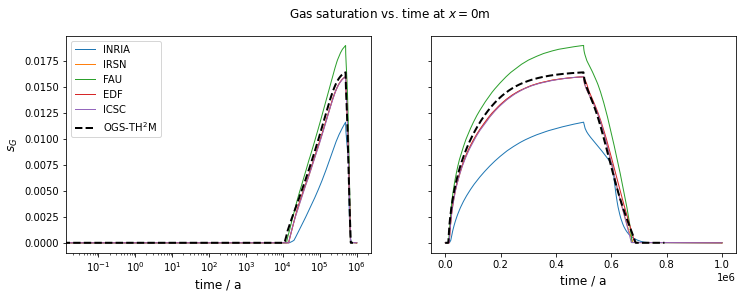

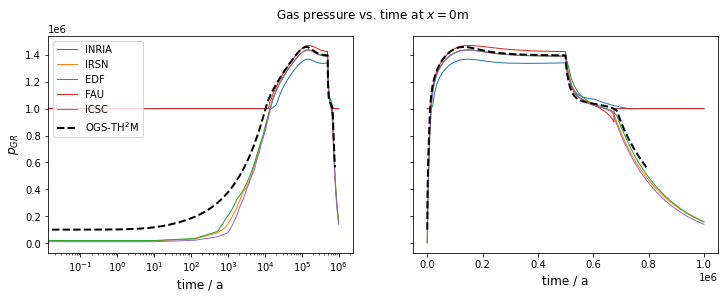

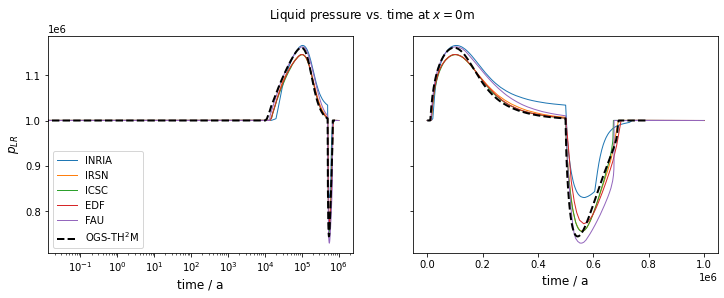

In [7]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 4)

# Loop over gas_saturation, gas_pressure, and liquid_pressure
for i in indices:
    index = indices[i]
    ref_time = refs[index]["time"]

    fig1, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    fig1.suptitle(i + r" vs. time at $x=0$m")

    ax1.set_xscale("log")
    ax1.set_xlabel("time / a", fontsize=12)
    ax1.set_ylabel(labels[index], fontsize=12)

    for r in range(1, len(refs[index].columns)):
        ax1.plot(
            ref_time,
            refs[index][refs[index].keys()[r]],
            linewidth=1,
            linestyle="-",
            label=refs[index].keys()[r],
        )

    ax1.plot(
        time_years,
        num_results[index],
        color="black",
        linewidth=2,
        linestyle="--",
        label="OGS-TH$^2$M",
    )

    ax2.set_xlabel("time / a", fontsize=12)

    for r in range(1, len(refs[index].columns)):
        ax2.plot(
            ref_time,
            refs[index][refs[index].keys()[r]],
            linewidth=1,
            linestyle="-",
            label=refs[index].keys()[r],
        )
    ax2.plot(
        time_years,
        num_results[index],
        color="black",
        linewidth=2,
        linestyle="--",
        label="OGS-TH$^2$M",
    )

    ax1.legend()


fig1.savefig("results_sG_pGR_pLR.pdf")

After about 10,000 years, the dissolution capacity of the liquid phase is exhausted and a separate gas phase is formed. From this point on, an increase in water pressure can be observed. This is shown in the liquid pressure plot
by comparison with the results shown in <cite>Bourgeat et al. (2013)</cite>.

Regarding the accuracy (especially during times t<10,000 years), it should be noted that the reference graphs from the original paper were digitised manually; in the paper, the graphs were only linearly plotted (like those shown here in the right column), so no real statement can be made about the accuracy of the results for times t<10,000 years.

The comparison of the time evolution of the water pressure, gas pressure und gas saturation shows that the numerical solution calculated by OGS6-TH2M is very close to the results shown in <cite>Bourgeat et al. (2013)</cite>.
Both the time of formation of the gas phase (approximately at t=15,000 a and the shape and magnitude of the resulting pressure rise and pressure drop due to switching off the source term are within the differences of the reference solutions.

It can be concluded that both the transport and the phase transition behaviour of the TH2M process have been successfully derived and implemented. The self-controlled appearance and disappearance of a free gas phase should be emphasised.